<a target="_blank" href="https://colab.research.google.com/github/lm2612/Tutorials/blob/main/4_computervision/4-ComputerVision_Classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Convolutional Neural Network Classifier

Today we will build convolutional neural network to classify pets using the [Oxford pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) which consists of thousands of photos of cats and dogs.

Import packages and load the dataset. We have chosen this dataset as it was one of torchvision's built-in datasets available from [https://pytorch.org/vision/main/datasets.html](https://pytorch.org/vision/main/datasets.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage, Compose, CenterCrop, Resize
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

# Transforms
img_to_tensor = ToTensor()
tensor_to_img = ToPILImage()
crop = CenterCrop(360)        # crop all images to same size (360 x 360)
resize = Resize(128)          # resize so images are smaller / computationally cheaper

# the Oxford pet dataset is labelled by 37 breeds of cats and dogs, but we
# will use the dataset to predict species cat (0) or dog (1)
# manually define transform to convert breed id (1-37) to species id (0/1)
cat_breed_ids = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]

def breed2species(breedid):
    if breedid in cat_breed_ids:
        return 0
    else:
        return 1

data = datasets.OxfordIIITPet(
    root="./",
    download=True,
    target_types = "category",
    transform=Compose([img_to_tensor, crop, resize]),
    target_transform=breed2species
)

100%|██████████| 792M/792M [00:27<00:00, 28.8MB/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:01<00:00, 11.7MB/s]


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


## Set up
First, use `torch.utils.data.random_split` to split the data into 80% training, 10% training and 10% validation.

In [2]:
training_data, validation_data, test_data = torch.utils.data.random_split(data, lengths=[0.8, 0.1, 0.1])

Check the shape of the images and what they look like: Use the transform `tensor_to_img()` to quickly plot images.

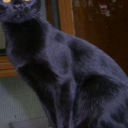

In [3]:
X, y = training_data[0]
tensor_to_img(X)

'''Line 2: tensor_to_img(X)

X: This variable now holds the image data, which is likely in the format of a PyTorch tensor.
tensor_to_img(): This is a function that converts a PyTorch tensor representing an image back
into a format suitable for displaying, such as a PIL Image.

Calling tensor_to_img(X) takes the image stored in X (which is a tensor) and converts it into
a displayable image format. This line would typically be used within a Jupyter Notebook or
similar environment to visualize the image.
'''

# These two lines essentially grab the first image and its label from your training data.
# The image is assigned to X, the label to y, and then the image (X) is converted into a viewable format using tensor_to_img()

In [4]:
X.shape

torch.Size([3, 128, 128])

## Create our dataloaders
Set up a dataloader for the training data with a batch size of 128 and a validation data with a batch size of 64.

In [5]:
dataloader = torch.utils.data.DataLoader(training_data,
                                         shuffle=True,
                                         batch_size=128)

dataloader_validation = torch.utils.data.DataLoader(validation_data,
                                         shuffle=True,
                                         batch_size=64)

In [6]:
len(training_data), len(validation_data)

(2944, 368)

In [9]:
# Get a test batch ready for testing the network layers
X_batch, y_batch = next(iter(dataloader_validation))

# prompt: # Check the shapes of X_batch, y_batch

print(X_batch.shape, y_batch.shape)

torch.Size([64, 3, 128, 128]) torch.Size([64])


## Test network layers
We will create a convolutional network with 3 layers. First, explore what the convolutions are doing.

Here is our first convolutional layer, that includes our convolution, RELU, BatchNorm and Pooling. Read the docs on [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and consider the choices for the arguments. `in_channels`, `out_channels`, and `kernel_size` are always needed, but you can also define `stride` and `padding`. Try some different choices and compare what the output shape is like.

In [10]:
conv_layer_1 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=3,
                      out_channels=3,
                      kernel_size=3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(3),
      torch.nn.MaxPool2d(2))

Test the first convolutional layer on X_batch. What shape is it? Plot it using `tensor_to_img()`.

In [ ]:
# Check shape of X_batch before and after applying conv_layer_1. Remember shape=(BATCH, CHANNELS, WIDTH, HEIGHT)

# Plot

Shape of X_batch before applying conv_layer_1: torch.Size([64, 3, 128, 128])
Shape of X_batch after applying conv_layer_1: torch.Size([64, 3, 63, 63])
torch.Size([3, 63, 63])


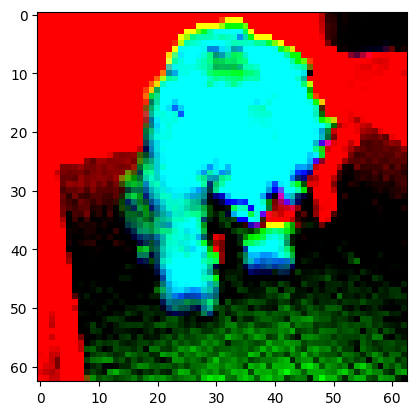

In [12]:
print("Shape of X_batch before applying conv_layer_1:", X_batch.shape)
X_batch_conv = conv_layer_1(X_batch)
print("Shape of X_batch after applying conv_layer_1:", X_batch_conv.shape)

# Plot the first image of the batch after convolution
first_image = X_batch_conv[0]
print(first_image.shape)

# Ensure the tensor is in the correct format and range for displaying
''' tensor is a fundamental data structure used to represent numerical data.
You can think of it as a multi-dimensional array or matrix. Tensors are the primary way
that data is stored and manipulated within neural networks.'''


first_image = first_image.detach().cpu() # move to cpu if on gpu and detach from gradient computation
first_image = torch.clamp(first_image, min=0, max=1) # Clamp values to be in the valid range [0,1]

# Convert to PIL image and display
to_pil_image = ToPILImage()
img = to_pil_image(first_image)
plt.imshow(img)
plt.show()

Notice the size of our tensor has changed: its smaller because of the convolution and pooling. We can see some features from the convolution, that highlight regions of the image where the gradient is quickly changing, which shows us outlines of objects in the image. For the second convolutional layer, we will use the same structure.

In [ ]:
conv_layer_2 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3,
                      out_channels = 3,
                      kernel_size = 3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(num_features = 3),
      torch.nn.MaxPool2d(kernel_size = 2))

Test this layer on the output of your previous layer. What shape is it?

In [ ]:
conv_layer_3 = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels = 3,
                      out_channels = 3,
                      kernel_size = 3,
                      padding=0),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(num_features = 3),
      torch.nn.MaxPool2d(kernel_size = 2))

Again, test this layer on the output of your previous layer. What shape is it?

Lastly, we will pass our tensor through a fully connected linear layer to get our output. Use the shape of the previous layer to deduce the number of features going into the linear layer. The size should be `NUM_CHANNELS * NUM_WIDTH * NUM_HEIGHT`.

In [ ]:
classifier = torch.nn.Sequential(
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=   ,
                      out_features=1),
      torch.nn.Sigmoid())

## Create model
Create a convolutional neural network classifier. As before, it needs to be a `torch.nn.Module` and have the method `forward`. Use the conv layers we have created above, but put them into the class below. Set up the forward module

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Create CNN in layers
        # first conv layer

        # second conv layer

        # third conv layer

        # classifier


    def forward(self, x):
        # first layer

        # second layer

        # third layer

        # classifier

        return x


Create an instance of ConvNet and test it on your first batch,

In [ ]:
# Create an instance of ConvNet

# Apply to first batch




## Set up loss function and optimiser
Decide on a suitable loss function for a classifier.

We will use Binary Cross Entropy (BCE). Test your loss function with the output of your network.

And we also need to set up our optimiser and provide our network parameters. Use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimiser.

## Training loop
Start the training loop - it will look similar to our training loop from this morning. You can expect it to take several minutes to run - that's why its always sensible to check you can run a smaller version of it first with a subset of the data.

In [ ]:
training_losses = []
validation_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    # Training loop


    # Validation loop


    # After every epoch print mean losses


In [ ]:
## Plot the training and validation losses on a logscale.



## Results

Write a function to convert the continuous output to zero or one so you can check if the prediction is correct.

Plot a few images from the validation dataset and set the title of each image to show if the network predicted "dog" or "cat"

Congratulations! You've built your own cat/dog classifier. Now try and improve upon it with more data. You could also try and predict the breed.

### Check convolutional layers

We discussed in class that convolutions act to either highlight or blur gradients in images, which help identify the shapes and edges of different objects. In general, the first few layers identify basic features within images and deeper layers identify more complex features (they also become more abstract and difficult to interpret!). We can try to investigate what our neural network has learned by looking at what each convolutional layer does after training. What are the convolutional layers doing after training?


In [ ]:
X_batch, y_batch = next(iter(dataloader_validation))

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()
axs[0].imshow(tensor_to_img(X_batch[0]))

# Layer 1:
X_conv = my_network.conv_layer_1(X_batch)
# Plot on axs[1]
axs[1].imshow(tensor_to_img(X_conv[0]))

# Layer 2:

# Plot on axs[2]


# Layer 3

# Plot on axs[3]

## Test dataset
Finally, apply on the test data set and calculate the number of true positives, false positives, true negatives and false negatives.


In [ ]:
dataloader_test = torch.utils.data.DataLoader(test_data,
                                         shuffle=True,
                                         batch_size=64)
